## Detecting Parkinson’s From the Spiral/Wave Test

In [5]:
!pip install opencv-python scikit-image scikit-learn


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
import os
import cv2
import numpy as np
from skimage import feature

##### Quantify the images using a HOG Descriptor

In [7]:
def quantify_image(image):
    features = feature.hog(image, orientations=9,
                           pixels_per_cell=(10, 10), cells_per_block=(2, 2),
                           transform_sqrt=True, block_norm="L1")
    return features

##### Loading the data and extracting the features

In [8]:
def load_split(path):
    imagePaths = list(paths.list_images(path))
    data = []
    labels = []
    # loop over the image paths
    for imagePath in imagePaths:
        label = imagePath.split(os.path.sep)[-2]
        image = cv2.imread(imagePath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (200, 200))
        image = cv2.threshold(image, 0, 255,
                              cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        features = quantify_image(image)
        data.append(features)
        labels.append(label)
    return (np.array(data), np.array(labels))

##### training the model

In [9]:
!pip install imutils xgboost matplotlib


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


### Training the model

In [10]:
def train_models(dataset):
    #initializing the models
    models = {
        "Rf": {
            "classifier": RandomForestClassifier(random_state=1),
            "accuracy": 0,
            "sensitivity": 0,
            "specificity": 0,
            "auc_score":0,
            "fpr":0,
            "tpr":0,
            "thresh":0
        },
        "Xgb": {
            "classifier": XGBClassifier(),
            "accuracy": 0,
            "sensitivity": 0,
            "specificity": 0,
            "auc_score": 0,
            "fpr":0,
            "tpr":0,
            "thresh":0
        }
    }
    path="Dataset/"+dataset
    trainingPath=os.path.sep.join([path,"training"])
    testingPath=os.path.sep.join([path,"testing"])
    #loading the data
    (trainX, trainY)=load_split(trainingPath)
    (testX, testY)=load_split(testingPath)
    
    le=LabelEncoder()
    trainY=le.fit_transform(trainY)
    testY=le.transform(testY)
    
    #training the model and calculating its metrics
    
    for model in models:
        models[model]['classifier'].fit(trainX,trainY)
        predictions=models[model]["classifier"].predict(testX)
        predictions_probs=models[model]["classifier"].predict_proba(testX)
        fpr, tpr, thresh = roc_curve(testY, predictions_probs[:,1])
        models[model]["fpr"] = fpr
        models[model]["tpr"] = tpr
        models[model]["thresh"] = thresh
        cm = confusion_matrix(testY, predictions).ravel()
        #getting the true positive false positive..... from the confuson matrix
        tn, fp, fn, tp = cm
        models[model]["accuracy"] = (tp + tn) / float(cm.sum())
        models[model]["sensitivity"] = tp / float(tp + fn)
        models[model]["specificity"] = tn / float(tn + fp)
        models[model]["auc_score"] = roc_auc_score(testY, predictions_probs[:,1])
        
    return models
    
    

In [11]:
from imutils import paths
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

In [12]:
# function to plot roc curve
def plot_roc_curve(model, figname):
    plt.style.use("seaborn")
    fpr_rf = model["Rf"]["fpr"]
    tpr_rf = model["Rf"]["tpr"]
    auc_score_rf =model["Rf"]["auc_score"]
    
    fpr_xgb = model["Xgb"]["fpr"]
    tpr_xgb = model["Xgb"]["tpr"]
    auc_score_xgb =model["Xgb"]["auc_score"]
    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr_rf, tpr_rf, color = 'blue', label = 'Random Forest AUC = {:.2f}'.format(auc_score_rf))
    plt.plot(fpr_xgb, tpr_xgb, color = 'green', label = 'Xgboost AUC = {:.2f}'.format(auc_score_xgb))
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1.1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.savefig(figname, dpi = 300)
    plt.show()

### Training the models on spiral drawings 

In [13]:
spiralModels=train_models('spiral')

#### Evaluating the performance of model on spiral diagrams

In [14]:
print("Random Forrest vs XGBoost Classifier\n\n")
for metric in ("accuracy", "sensitivity", "specificity", "auc_score"):
    print(f"{metric.capitalize()}: ")
    print("Random Forrest={:.2f}%, XGBoost={:.2f}% \n".format(
        spiralModels['Rf'][metric]*100, spiralModels['Xgb'][metric]*100))

Random Forrest vs XGBoost Classifier


Accuracy: 
Random Forrest=86.67%, XGBoost=73.33% 

Sensitivity: 
Random Forrest=80.00%, XGBoost=73.33% 

Specificity: 
Random Forrest=93.33%, XGBoost=73.33% 

Auc_score: 
Random Forrest=86.89%, XGBoost=87.11% 



#### Roc curve for the spiral diagrams

C:\Users\asus\AppData\Local\Temp\ipykernel_2132\445968254.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


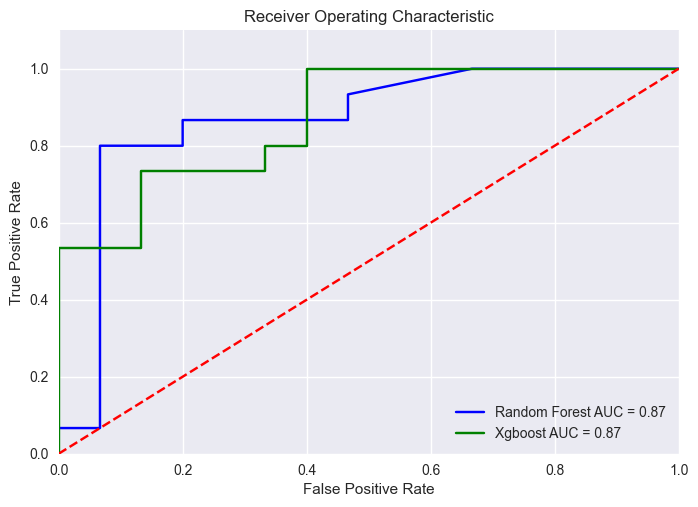

In [15]:
plot_roc_curve(spiralModels, 'spirals')

#### -For the spiral images we can conclude that Random forest will outperform XGBoost in all the cases 

###### 1)Accuracy of Random Forest 86.67%
###### 2)Accuracy of XGBoost 73.33%

#### -The specificity is even much higher

###### 1)Specificity of Random Forest 93.33%
###### 2)Specificity of XGBoost 73.33%




### Testing on Sample images

In [16]:
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
def test_prediction(model, testingPath):
    testingPath=list(paths.list_images(testingPath))
    output_images=[]
    #selecting the images
    for _ in range(15):
        image = cv2.imread(random.choice(testingPath))
        output = image.copy()
        output = cv2.resize(output, (128, 128))
        #pre_process the image
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (200, 200))
        image = cv2.threshold(image, 0, 255,
                              cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        #make prediction based on the model
        features = quantify_image(image)
        preds = model.predict([features])
        label = "Parkinsons" if preds[0] else "Healthy"
        
        #getting colored labels on top of the image
        color = (0, 255, 0) if label == "Healthy" else (0, 0, 255)
        cv2.putText(output, label, (3, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                    color, 2)
        output_images.append(output)
    plt.figure(figsize=(20, 20))
    #printing the images
    for i in range(len(output_images)):
        plt.subplot(5, 5, i+1)
        plt.imshow(output_images[i])
        plt.axis("off")
    plt.show()

##### Output

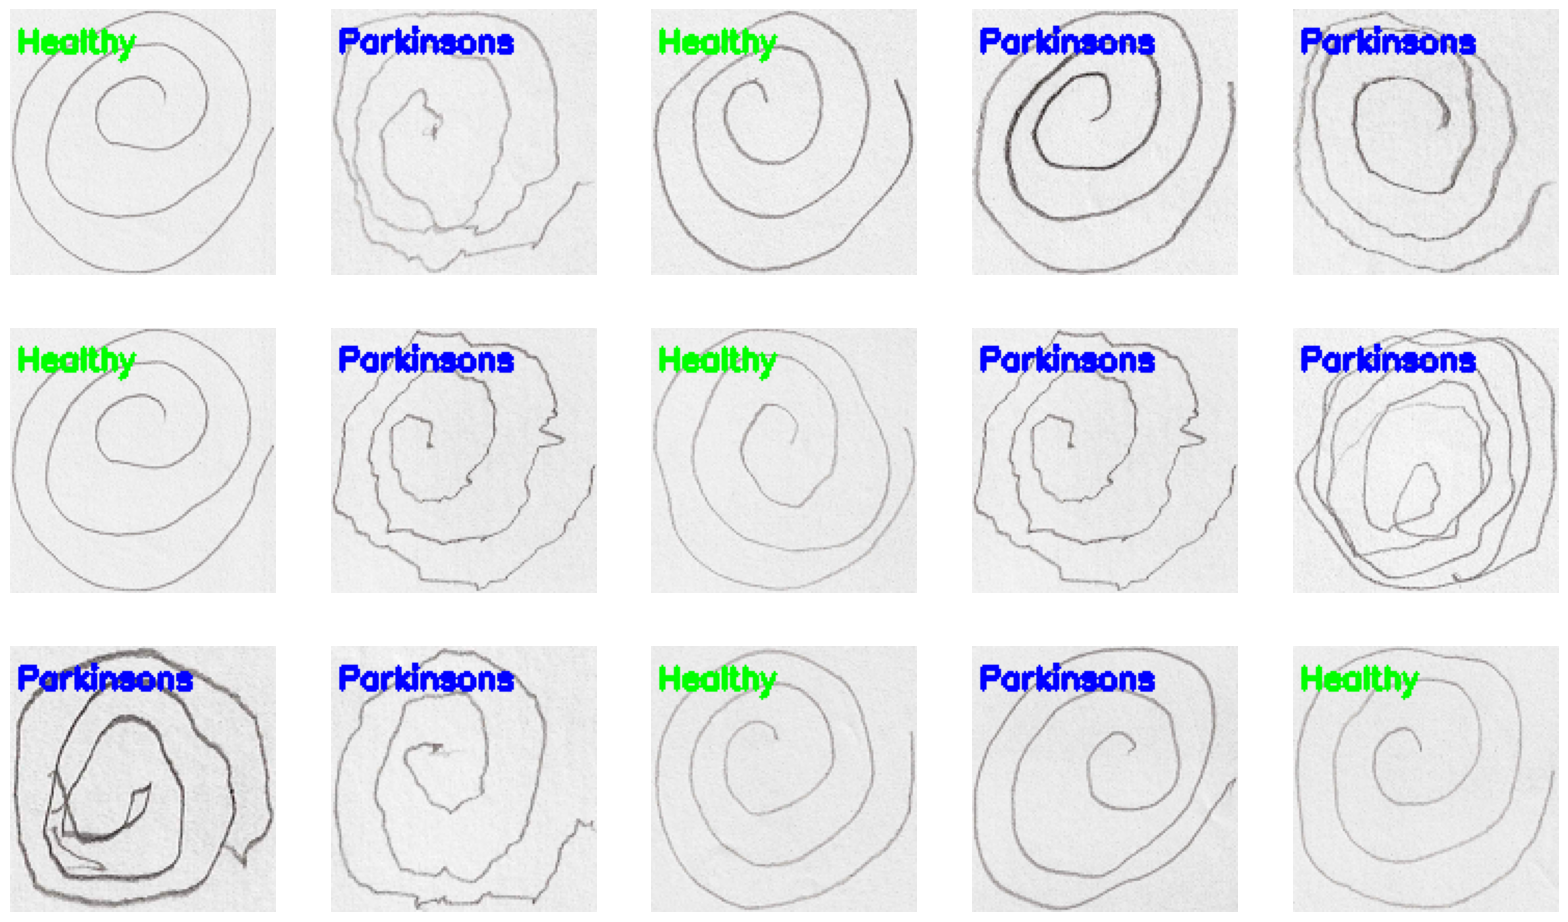

In [18]:
testingPath = os.path.sep.join(["dataset/spiral", "testing"])
test_prediction(spiralModels['Rf']['classifier'], testingPath)

## Training the models on wave dataset


In [19]:
waveModels=train_models('wave')

#### evaluating the performance of the model

In [20]:
print("Random Forrest vs XGBoost Classifier\n\n")
for metric in ("accuracy", "sensitivity", "specificity", "auc_score"):
    print(f"{metric.capitalize()}: ")
    print()
    print("Random Forrest={:.2f}%, XGBoost={:.2f}% \n".format(
        waveModels['Rf'][metric]*100, waveModels['Xgb'][metric]*100))

Random Forrest vs XGBoost Classifier


Accuracy: 

Random Forrest=76.67%, XGBoost=70.00% 

Sensitivity: 

Random Forrest=73.33%, XGBoost=73.33% 

Specificity: 

Random Forrest=80.00%, XGBoost=66.67% 

Auc_score: 

Random Forrest=82.44%, XGBoost=79.11% 



#### Roc curve for the spiral diagrams

C:\Users\asus\AppData\Local\Temp\ipykernel_2132\445968254.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


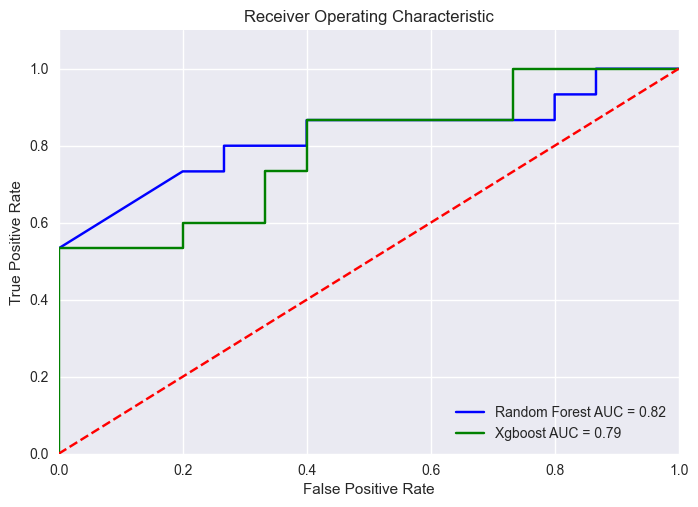

In [21]:
plot_roc_curve(waveModels,'wave')

#### -For the wave images we can conclude that Random forest will outperform XGBoost in all the cases 

###### 1)Accuracy of Random Forest 76%
###### 2)Accuracy of XGBoost 70%

#### -The specificity is even much higher

###### 1)Specificity of Random Forest 80%
###### 2)Specificity of XGBoost 66%




## Testing on sample images

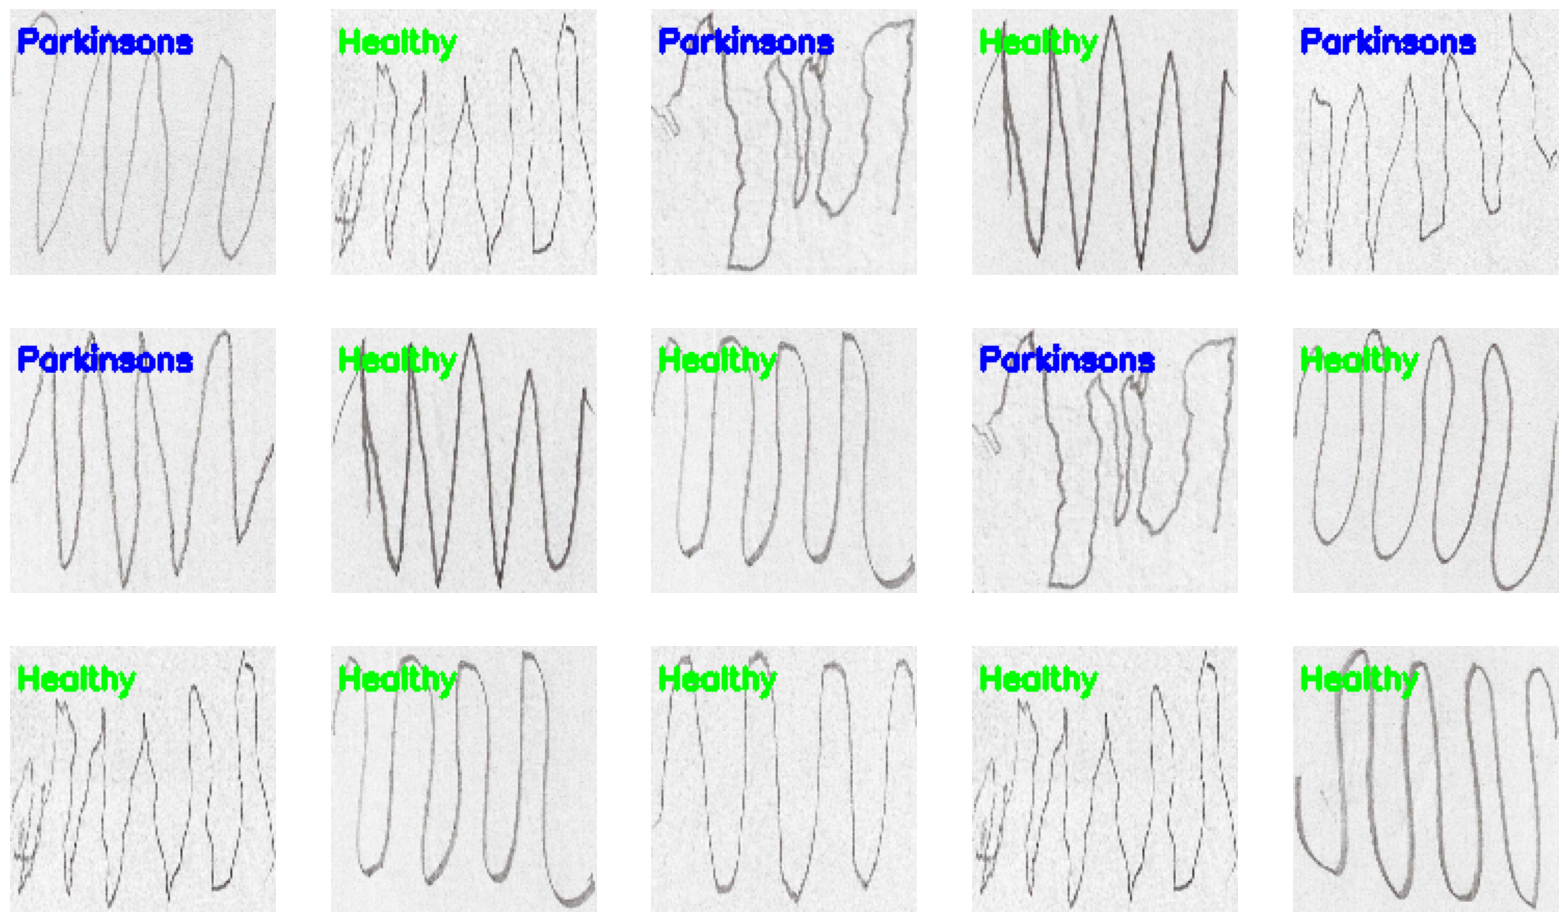

In [22]:
testingPath=os.path.sep.join(["dataset/wave","testing"])
test_prediction(waveModels['Rf']['classifier'],testingPath)

## saving the model for later use


In [25]:
import joblib

In [32]:
filename = os.path.join("models/", "random_forest_spiral_model.pkl")
joblib.dump(spiralModels['Rf']['classifier'], filename)

['models/random_forest_spiral_model.pkl']

In [38]:
filename = os.path.join("models/", "XG_boost_spiral_model.pkl")
joblib.dump(spiralModels['Xgb']['classifier'], filename)

['models/XG_boost_spiral_model.pkl']

In [33]:
filename=os.path.join("models/","random_forest_wave_model.pkl")
joblib.dump(waveModels['Rf']['classifier'], filename)

['models/random_forest_wave_model.pkl']

## Testing on the saved models

In [34]:
filename = os.path.join("models/", "random_forest_spiral_model.pkl")
spiralmodel = joblib.load(filename)

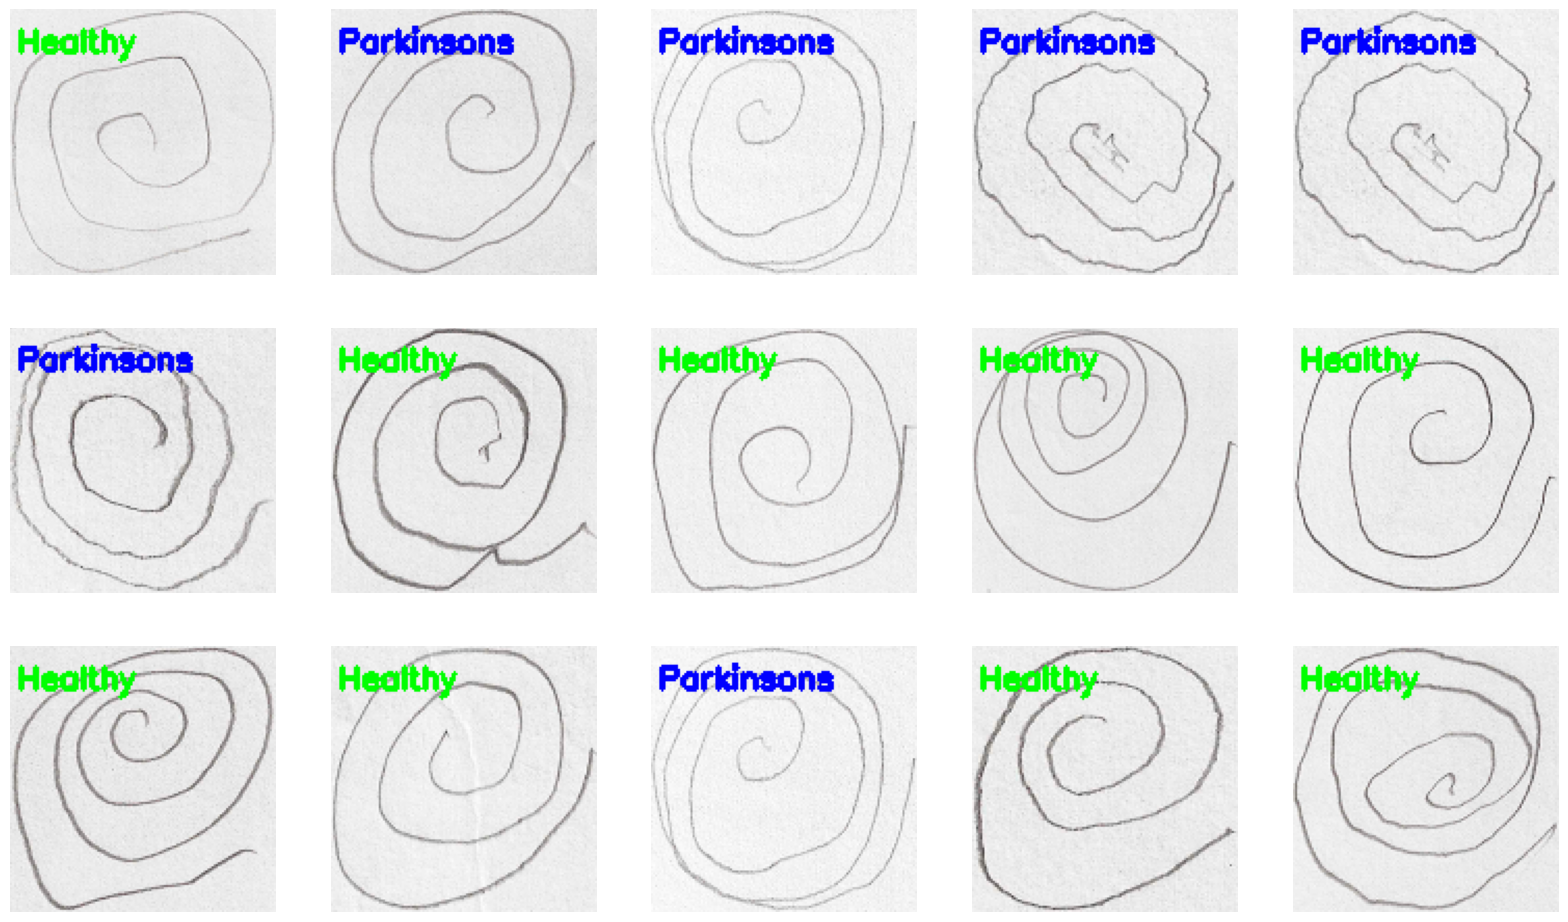

In [35]:
testingPath = os.path.sep.join(["dataset/spiral", "testing"])
test_prediction(spiralmodel, testingPath)

In [36]:
filename = os.path.join("models/", "random_forest_wave_model.pkl")
waveModel = joblib.load(filename)

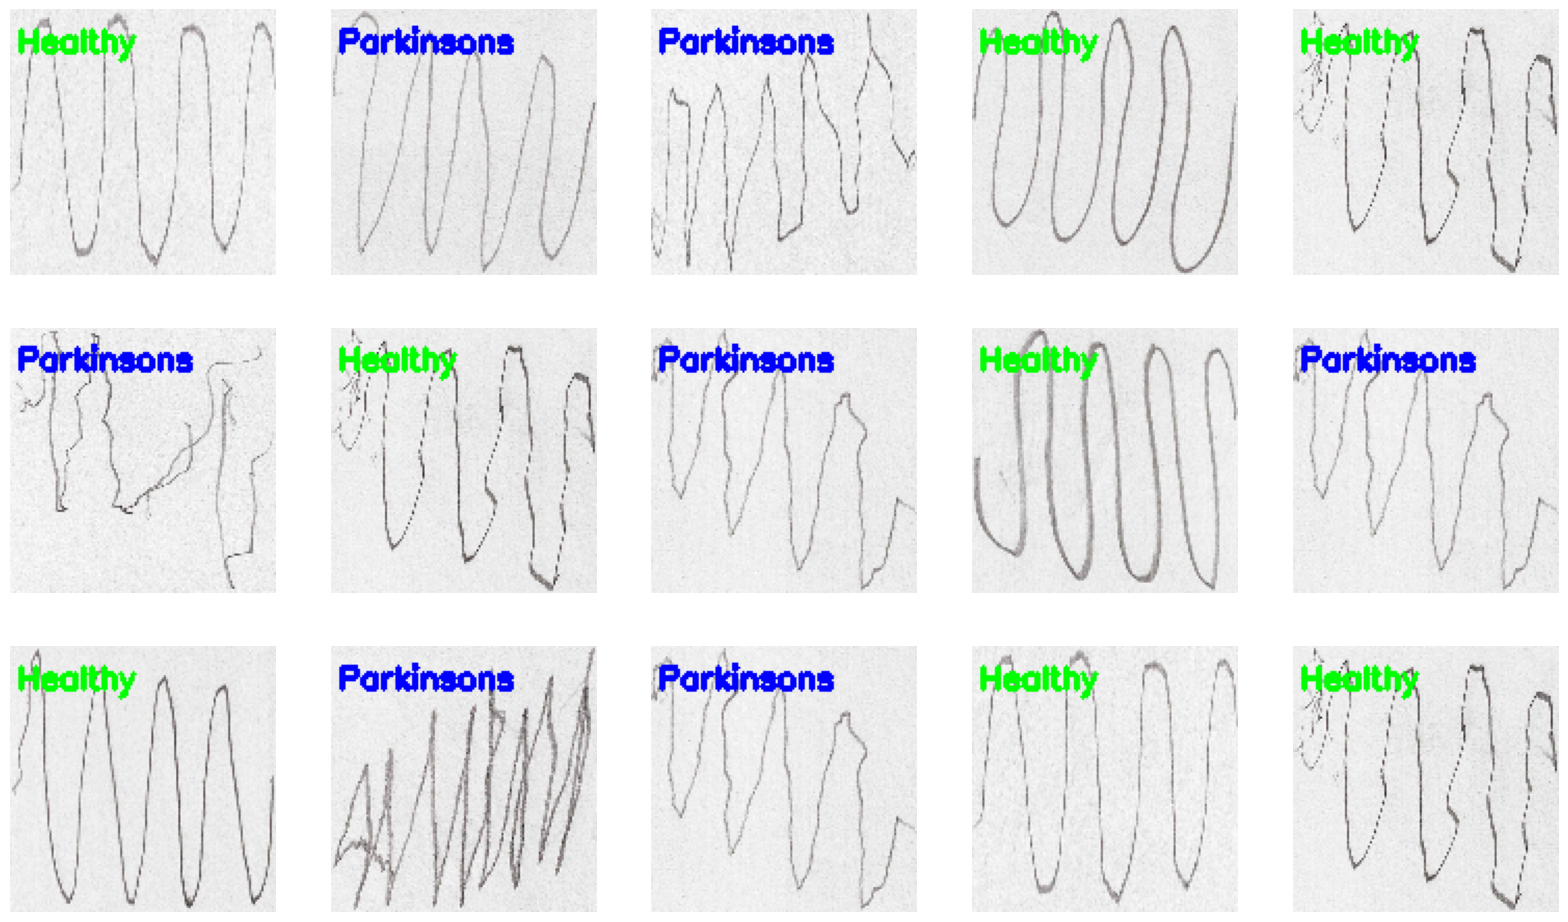

In [37]:
testingPath = os.path.sep.join(["dataset/wave", "testing"])
test_prediction(waveModel, testingPath)